# High Winds - AIFS
---

Winter storms had a tremendous impact on Sweden during the first week of January. A low-pressure system named Floriane impacted various parts of north-western Europe.

This example shows analysis of the selected parameters:
- [`msl`](https://codes.ecmwf.int/grib/param-db/151) mean sea level pressure,
- [`tp`](https://codes.ecmwf.int/grib/param-db/228228) total precipitation of the **AIFS** datasets on 7 January 2025 in Sweden (58.58° N, 11.07° E).

## 1. Set Up Your Environment and Find ECMWF Open Data
Open data will be downloaded from a publicly available [Amazon S3 Bucket](../datadownload/find-data.md). First, the following Python libraries need to be installed in the current Jupyter kernel:
- `requests` to send HTTP requests,
- `itertools` to create iterators for efficient looping,
- `json` to decode JSON data,
- `xarray` to work with labelled multi-dimensional arrays, and
- `earthkit` to analyse and plot the data.

:::{seealso}
More detailed information about how to install Python packages is available on the [Retrieve Data](../datadownload/data-download.ipynb) website.
:::
If the packages are not installed yet, uncomment the code below and run it.

In [ ]:
# !pip3 install earthkit requests itertools json xarray

In [55]:
import requests
import itertools
import json

import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit

import xarray as xr
xr.set_options(keep_attrs=True)

(content:references:listParam_dwa)=
### List of parameters to retrieve from open datasets
The selected values below can be modified.
- Parameters available on a single level:

In [29]:
PARAM_SFC = "msl" # "tp"
LEVELTYPE = "sfc"

DATES = [20250104, 20250105, 20250106, 20250107, 20250108]
TIME = 0
STEPS = [24] # [12, 24]
STREAM = "oper"
TYPE = "fc"
MODEL = "aifs"
RESOL = "0p25"

:::{important}
Ensure you specify the model correctly! <br>
Before March 2025, the file-naming convention was different. In this case, we will use the `earthkit-data` package to retrieve our data instead of `ecmwf-opendata`.
For more information, visit the [Amazon S3 Buckets](../datadownload/source-aws.ipynb) website.
:::

### Get the data using the `earthkit-data` package
First we will extract information about the offset and length, byte ranges we want to read from a GRIB file.

In [30]:
def get_parts_index(date, time, step, stream, _type, model, resol, param, levelist=[]):
    """
    this function takes one parameter on a single level or a pressure level and
    returns its corresponding byte ranges extracted from the index file within a defined date range. 
    """
    
    parts = []
    timez = f"{time}".zfill(2)

    for _date in DATES:
        for _step in STEPS:
            index = f"{_date}/{timez}z/{model}/{resol}/{stream}/{_date}{timez}0000-{_step}h-{stream}-{_type}.index"        
            url = f"https://ecmwf-forecasts.s3.amazonaws.com/{index}"
            print(url)
            try:
                r = requests.get(url)
                for i, line in enumerate(r.iter_lines()):
                    line = json.loads(line)
                    if levelist == []:
                        if line.get("param") == param:
                            offset = line["_offset"]
                            length = line["_length"]
                            parts.append((offset, length))
                    else:
                        if line.get("levelist") == f"{levelist}" and line.get("param") == param:
                            offset = line["_offset"]
                            length = line["_length"]
                            parts.append((offset, length))
            except:
                print(f'Cannot find the selected index file {index}.')
    return parts

In [31]:
def get_open_data_earthkit(date, time, step, stream, _type, model, resol, parts, scale):
    files = ekd.SimpleFieldList()
    timez = f"{time}".zfill(2)

    # Get the data for all dates and steps
    for _date in DATES:
        for _step in STEPS:
            filename = f"{_date}/{timez}z/{model}/{resol}/{stream}/{_date}{timez}0000-{_step}h-{stream}-{_type}.grib2"
            data = ekd.from_source("s3", {
                "endpoint": "s3.amazonaws.com",
                "region": "eu-central-1",
                "bucket": "ecmwf-forecasts",
                "objects": { "object": filename, "parts": parts.pop(0)},
                }, anon=True)
            md = data.metadata()
            v = data.to_array() / scale
            for f in range(len(md)):
                files.append(ekd.ArrayField(v[f], md[f]))
    return files

## 2. Total precipitation
The input values can be set [here](#content:references:listParam_dwa).

In [14]:
parts_pair = get_parts_index(date=DATES,
                        time=TIME,
                        step=STEPS,
                        stream=STREAM,
                        _type=TYPE,
                        model=MODEL,
                        resol=RESOL,
                        param=PARAM_SFC,
                        levelist=[])
parts_pair

https://ecmwf-forecasts.s3.amazonaws.com/20250104/00z/aifs/0p25/oper/20250104000000-12h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250104/00z/aifs/0p25/oper/20250104000000-24h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250105/00z/aifs/0p25/oper/20250105000000-12h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250105/00z/aifs/0p25/oper/20250105000000-24h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250106/00z/aifs/0p25/oper/20250106000000-12h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250106/00z/aifs/0p25/oper/20250106000000-24h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250107/00z/aifs/0p25/oper/20250107000000-12h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250107/00z/aifs/0p25/oper/20250107000000-24h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250108/00z/aifs/0p25/oper/20250108000000-12h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250108/00z/aifs/0p25/oper/2025010800000

[(24225153, 845404),
 (43801645, 941353),
 (35521323, 845843),
 (38581813, 942587),
 (12135540, 846304),
 (13769897, 945028),
 (17586219, 722619),
 (38844867, 816531),
 (50391246, 843926),
 (42232891, 814348)]

In [17]:
ds = get_open_data_earthkit(date=DATES,
                               time=TIME,
                               step=STEPS,
                               stream=STREAM,
                               _type=TYPE,
                               model=MODEL,
                              resol=RESOL,
                              parts=parts_pair,
                              scale = 1)

In [19]:
# Select AIFS model data from 4 to 8 January 2025
ds.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,tp,surface,0,20250104,0,0-12,fc,None,regular_ll
1,ecmf,tp,surface,0,20250104,0,0-24,fc,None,regular_ll
2,ecmf,tp,surface,0,20250105,0,0-12,fc,None,regular_ll
3,ecmf,tp,surface,0,20250105,0,0-24,fc,None,regular_ll
4,ecmf,tp,surface,0,20250106,0,0-12,fc,None,regular_ll
5,ecmf,tp,surface,0,20250106,0,0-24,fc,None,regular_ll
6,ecmf,tp,surface,0,20250107,0,0-12,fc,None,regular_ll
7,ecmf,tp,surface,0,20250107,0,0-24,fc,None,regular_ll
8,ecmf,tp,surface,0,20250108,0,0-12,fc,None,regular_ll
9,ecmf,tp,surface,0,20250108,0,0-24,fc,None,regular_ll


A unit of total precipitation is kg/m$^2$. 1 kg of rainwater fills an area of 1 m$^2$ with the water of height 1 mm. <br>
In the [ECMWF Open Charts](https://charts.ecmwf.int/), total precipitation is also plotted in millimetres.

The `tp` parameter gives information about total accumulated rainfall from the start of the forecast onwards. For instance, `step=12` indicates accumulated precipitation from 00 UTC until 12 UTC, `step=24` from 00 UTC to 00 UTC in the next day. <br>

To plot the total precipitation between the steps 12 and 24, we need the data on both timesteps and substract the precipitation on `step=24` from `step=12`.

In [28]:
tp_12 = ds.sel(step=12).to_xarray()
tp_24 = ds.sel(step=24).to_xarray()
tp24_12 = tp_24 - tp_12
tp = tp24_12.earthkit.to_fieldlist()
tp.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,tp,surface,0,20250104,0,0-24,fc,None,regular_ll
1,ecmf,tp,surface,0,20250105,0,0-24,fc,None,regular_ll
2,ecmf,tp,surface,0,20250106,0,0-24,fc,None,regular_ll
3,ecmf,tp,surface,0,20250107,0,0-24,fc,None,regular_ll
4,ecmf,tp,surface,0,20250108,0,0-24,fc,None,regular_ll


## 3. Mean sea level pressure
The input values can be set [here](#content:references:listParam_dwa). <br>
We will plot mean sea level pressure data in hPa, therefore we need to divide them by 100.

In [32]:
parts_pair = get_parts_index(date=DATES,
                        time=TIME,
                        step=STEPS,
                        stream=STREAM,
                        _type=TYPE,
                        model=MODEL,
                        resol=RESOL,
                        param=PARAM_SFC,
                        levelist=[])
parts_pair

https://ecmwf-forecasts.s3.amazonaws.com/20250104/00z/aifs/0p25/oper/20250104000000-24h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250105/00z/aifs/0p25/oper/20250105000000-24h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250106/00z/aifs/0p25/oper/20250106000000-24h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250107/00z/aifs/0p25/oper/20250107000000-24h-oper-fc.index
https://ecmwf-forecasts.s3.amazonaws.com/20250108/00z/aifs/0p25/oper/20250108000000-24h-oper-fc.index


[(63582116, 476879),
 (18622014, 475416),
 (63177182, 473847),
 (31854527, 477943),
 (59839874, 479944)]

In [33]:
msl = get_open_data_earthkit(date=DATES,
                             time=TIME,
                             step=STEPS,
                             stream=STREAM,
                             _type=TYPE,
                             model=MODEL,
                             resol=RESOL,
                             parts=parts_pair,
                             scale = 100)
msl.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,msl,meanSea,0,20250104,0,24,fc,None,regular_ll
1,ecmf,msl,meanSea,0,20250105,0,24,fc,None,regular_ll
2,ecmf,msl,meanSea,0,20250106,0,24,fc,None,regular_ll
3,ecmf,msl,meanSea,0,20250107,0,24,fc,None,regular_ll
4,ecmf,msl,meanSea,0,20250108,0,24,fc,None,regular_ll


## 4. Data visualisation

The plots below show analyses of total precipitation and mean sea level pressure from 4 to 8 January 2025.

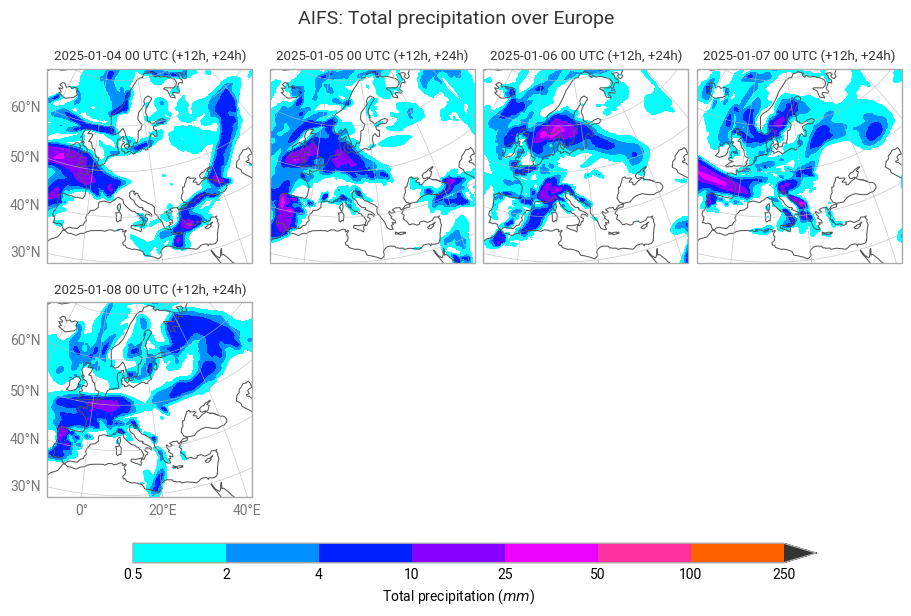

In [39]:
figure = ekp.Figure(domain="Europe", size=(9, 8), rows=3, columns=4)

hex_colours = ['#00ffff', '#0080ff', '#0000ff', '#d900ff', '#ff00ff', '#ff8000', '#ff0000', '#333333', ]

tp_shade = ekp.styles.Style(
    colors = hex_colours,
    levels = [0.5, 2, 4, 10, 25, 50, 100, 250],
    units = "mm",
    extend = "max",
)

for i in range(5):
    figure.add_map(1+i//4, i%4)
figure.contourf(tp, style=tp_shade)

figure.coastlines(resolution="low")
figure.gridlines()

figure.legend(location="bottom", label="{variable_name} ({units})")

figure.subplot_titles("{base_time:%Y-%m-%d %H} UTC (+12h, +24h)")
figure.title(
    "AIFS: {variable_name} over {domain}\n",
    fontsize=14, horizontalalignment="center",
)
figure.save(fname=f"./plots/{PARAM_SFC}_{MODEL}_{DATES[-1]}{TIME}-{STEPS[-1]}h.png")
figure.show()

:::{important}
The `earthkit` package is in development and subject to ECMWF's guidelines on [Software Maturity](https://github.com/ecmwf/codex/tree/refs/heads/main/Project%20Maturity).
:::

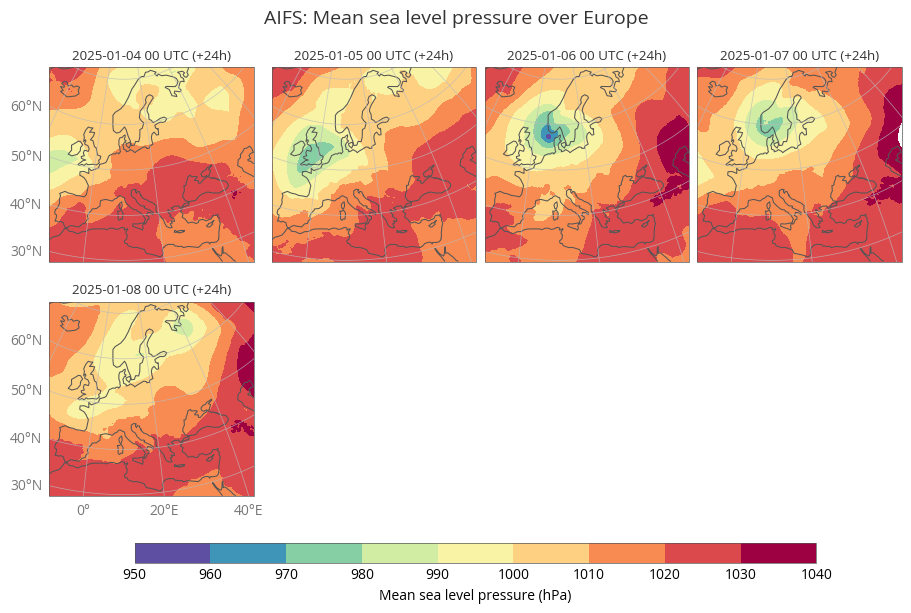

In [65]:
figure = ekp.Figure(domain="Europe", size=(9, 8), rows=3, columns=4)

msl_shade = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(950, 1050, 10),
    transform_first=True,
)

for i in range(5):
    figure.add_map(1+i//4, i%4)
figure.contourf(msl, style=msl_shade)

figure.coastlines(resolution="low")
figure.gridlines()

figure.legend(location="bottom", label="{variable_name} (hPa)")

figure.subplot_titles("{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)")
figure.title(
    "AIFS: {variable_name} over {domain}\n",
    fontsize=14, horizontalalignment="center",
)
figure.save(fname=f"./plots/{PARAM_SFC}_{MODEL}_{DATES[-1]}{TIME}-{STEPS[-1]}h.png")
figure.show()